# Spatial Analysis
## NutriNet: Maya Coronado, Savannah Gourley, Xander Lee, Kiran Rao
In our group project, we aim to isolate contributing factors to low birth weight throughout the city of Los Angeles, focusing on SPA  4 & 5. As our data is aggregated at the census tract level, we decided to isolate a main contributing factor and look at food insecurity. We want to contextualize and focus on the Low Birth Weight rates of specific census tracts and overlay it with the clustering of SNAP accepting retailers. The aim is to see if there are clusters of SNAP accepters and what that relates to. We have an initial hypothesis that in neighborhoods with high rates of low gestational birth there will be more SNAP retailers; the amount of CalFresh cases in a certain census tract is also being used as a contributing variable to understand the food insecurity rate of certain regions. 

Below, we will do some data "wrangling" and clean up, merging together our relevant data sets with other relevant groups. Before completing a pearson's correlation analysis on our primary indicator variables and a spatial autocorrelation analysis identifying clusters of SNAP retailers and of Low Birth Weight rates.

In [1]:
# to read and wrangle data
import pandas as pd
import numpy as np

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px



In [2]:
df = pd.read_csv('data/Main Data - main (1).csv')
censusdata = gpd.read_file('data/Census_Tracts_2020.geojson')

In [3]:
censusdata['tract']='06' + '037' + censusdata ['CT20']

In [4]:
df.columns = ['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa',
       'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth_Rate',
       'Fertility_Rate', 'Low_Birth_Weight', 'Low_Birth_Weight_Pctl',
       'median_income', 'Grocery Store Access',
       'GSA_Percent','CalFresh_Cases','CF cases per 100']
df.columns

Index(['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa', 'ESRI_OID',
       'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth_Rate',
       'Fertility_Rate', 'Low_Birth_Weight', 'Low_Birth_Weight_Pctl',
       'median_income', 'Grocery Store Access', 'GSA_Percent',
       'CalFresh_Cases', 'CF cases per 100'],
      dtype='object')

In [5]:
df['census_tract']='0'+ df['tract'].apply(str)

Note: Because our data is at the tract level, we also kept the boundaries/blocks of our census tracts appropiately. 

In [6]:
df.head()

,Unnamed: 0,ignore,tract,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,Total Woman 15-50,...,Birth_Rate,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,census_tract
0,0,6037199700,6037199700,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463240,678,...,0.006779,0.033923,6.52,83.85,38892.0,0.0,0.0,301.0,43.8,06037199700
1,0,6037199801,6037199801,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,911,...,0.027997,0.093304,0.00,0.00,41027.0,0.0,0.0,286.0,36.2,06037199801
2,0,6037199802,6037199802,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,458,...,0.006996,0.032751,0.00,0.00,42500.0,0.0,0.0,242.0,49.1,06037199802
3,0,6037199900,6037199900,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728020,573,...,0.003786,0.017452,5.43,62.88,37232.0,0.0,0.0,264.0,50.7,06037199900
4,0,6037201110,6037201110,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383640,715,...,0.015866,0.051748,7.08,90.67,65000.0,0.0,0.0,136.0,26.0,06037201110


In [7]:
censusdata.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [8]:
censusdata['census_tract']='06' + '037' + censusdata ['CT20']

In [9]:
LBW=censusdata.merge(df,on="census_tract")

In [10]:
SPA=gpd.read_file('data/Service_Planning_Areas_2022_(view).geojson')

In [11]:
selected_SPAs = SPA[SPA['LABEL'].isin(['SPA 4','SPA 5'])]

In [12]:
our_SPA=gpd.GeoDataFrame(selected_SPAs)

In [13]:
SNAP= pd.read_csv('data/SNAP_Retailer_Location_data.csv')

In [14]:
SNAP.shape

(8132, 17)

In [15]:
SNAP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     8132 non-null   float64
 1   Y                     8132 non-null   float64
 2   Record_ID             8132 non-null   int64  
 3   Store_Name            8132 non-null   object 
 4   Store_Street_Address  8132 non-null   object 
 5   Additonal_Address     746 non-null    object 
 6   City                  8132 non-null   object 
 7   State                 8132 non-null   object 
 8   Zip_Code              8132 non-null   int64  
 9   Zip4                  8132 non-null   object 
 10  County                8132 non-null   object 
 11  Store_Type            8132 non-null   object 
 12  Latitude              8132 non-null   float64
 13  Longitude             8132 non-null   float64
 14  Incentive_Program     89 non-null     object 
 15  Grantee_Name         

In [16]:
SNAP = gpd.GeoDataFrame(SNAP, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(SNAP.X, SNAP.Y))

In [17]:
SNAP_clip = gpd.clip(SNAP, our_SPA)

In [18]:
SNAP_clip = SNAP_clip.to_crs(epsg=3857)

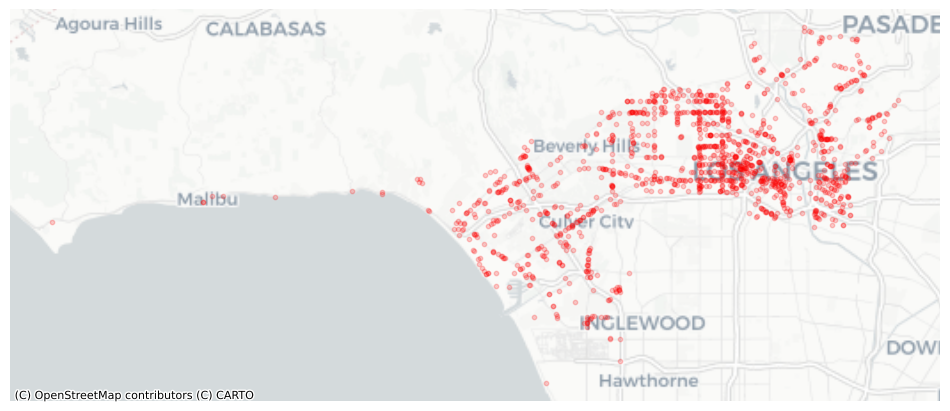

In [19]:
fig,ax = plt.subplots(figsize=(12,12))

SNAP_clip.plot(ax=ax,
             color='red',
             markersize=10,
              alpha=0.2)

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Above, we've successfully mapped all SNAP retailers in SPA 4 & 5. We can immediately see a clustering towards downtown and spacing out towards the Westside.

In [20]:
minx, miny, maxx, maxy = SNAP_clip.geometry.total_bounds
print(minx)

-13225808.588623803


In [21]:
LBW.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   OBJECTID                     537 non-null    int64   
 1   CT20                         537 non-null    object  
 2   LABEL                        537 non-null    object  
 3   ShapeSTArea                  537 non-null    float64 
 4   ShapeSTLength                537 non-null    float64 
 5   geometry                     537 non-null    geometry
 6   tract_x                      537 non-null    object  
 7   census_tract                 537 non-null    object  
 8   Unnamed: 0                   537 non-null    int64   
 9   ignore                       537 non-null    int64   
 10  tract_y                      537 non-null    int64   
 11  sup_dist                     537 non-null    object  
 12  csa                          537 non-null    object  
 1

In [22]:
LBW = LBW.to_crs(epsg=3857)

In [23]:
SNAP_clip = SNAP_clip.to_crs(epsg=3857)

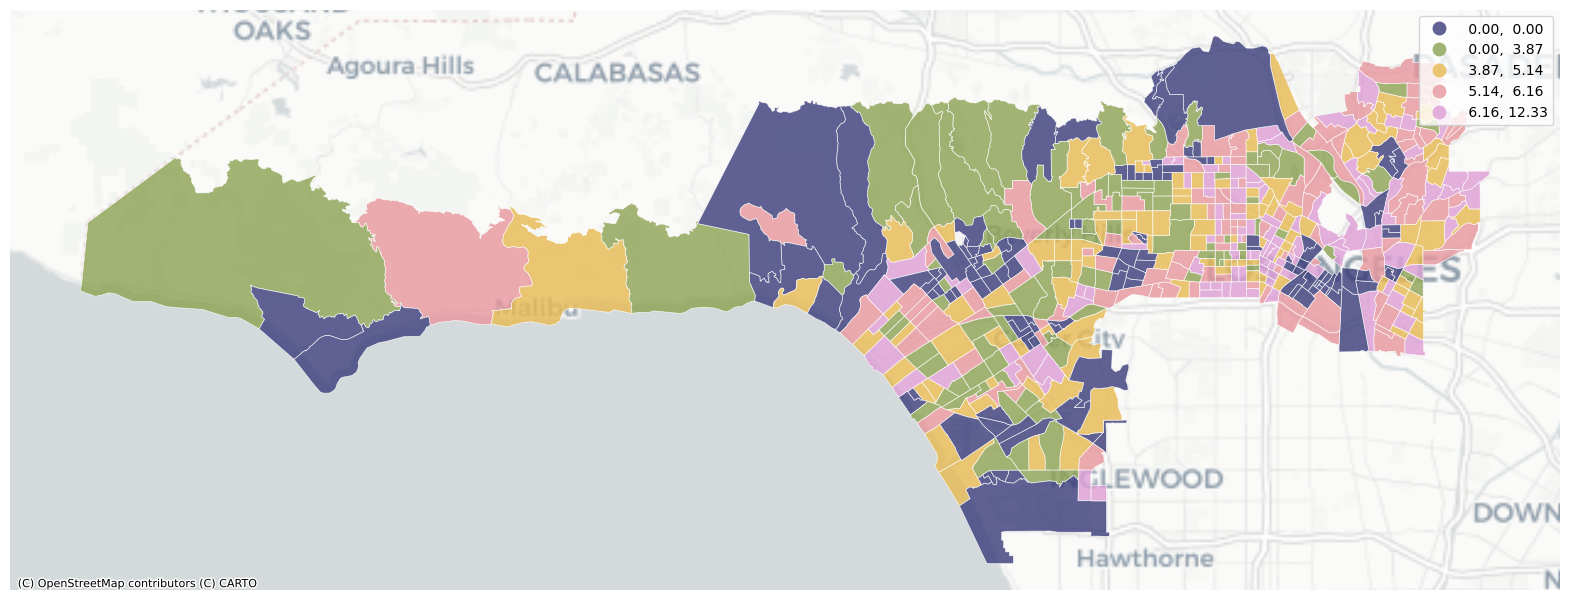

In [24]:

# plot it!
fig, ax = plt.subplots(figsize=(20,20))

LBW.plot(ax=ax,
         column='Low_Birth_Weight',
         scheme='quantiles', 
         edgecolor='white',
         cmap='tab20b',
         legend=True,
         lw=0.5,
         alpha=0.8)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

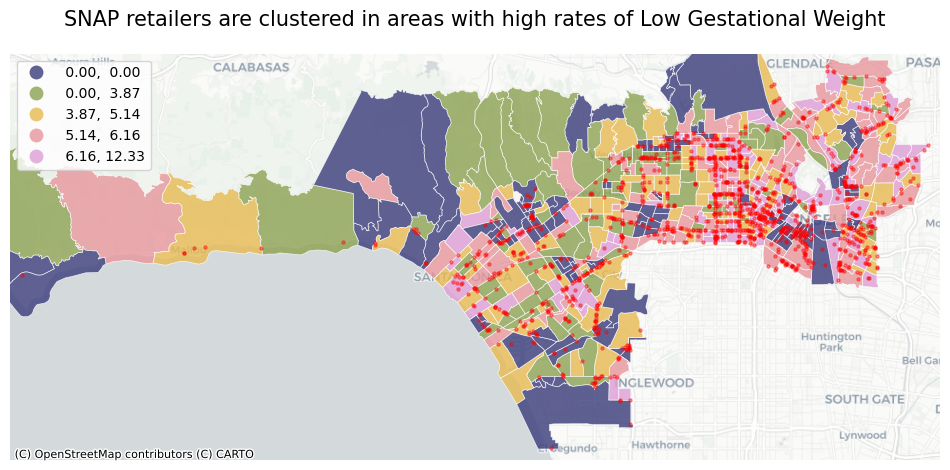

In [25]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='Low_Birth_Weight',
         scheme='quantiles', 
         edgecolor='white',
         cmap='tab20b',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')
ax.set_title('SNAP retailers are clustered in areas with high rates of Low Gestational Weight',fontsize=15,pad=20)


# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

For our project's purposes, we've gone ahead and created the base map looking at the % of Low Birth Weights on a census tract level and see significant clustering again by the downtown area. 

From here, we will conduct a join function to allow us to isolate the amount of SNAP retailers per census tract and pull out significant tracts. 

In [26]:
join = gpd.sjoin(LBW, SNAP_clip, how='left')

In [27]:
join.shape

(1503, 47)

In [28]:
join.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth_Rate', 'Fertility_Rate', 'Low_Birth_Weight',
       'Low_Birth_Weight_Pctl', 'median_income', 'Grocery Store Access',
       'GSA_Percent', 'CalFresh_Cases', 'CF cases per 100', 'index_right', 'X',
       'Y', 'Record_ID', 'Store_Name', 'Store_Street_Address',
       'Additonal_Address', 'City', 'State', 'Zip_Code', 'Zip4', 'County',
       'Store_Type', 'Latitude', 'Longitude', 'Incentive_Program',
       'Grantee_Name', 'ObjectId'],
      dtype='object')

In [29]:
SNAP_by_tract = join.census_tract.value_counts().rename_axis('census_tract').reset_index(name='SNAP_count')


<Axes: xlabel='census_tract'>

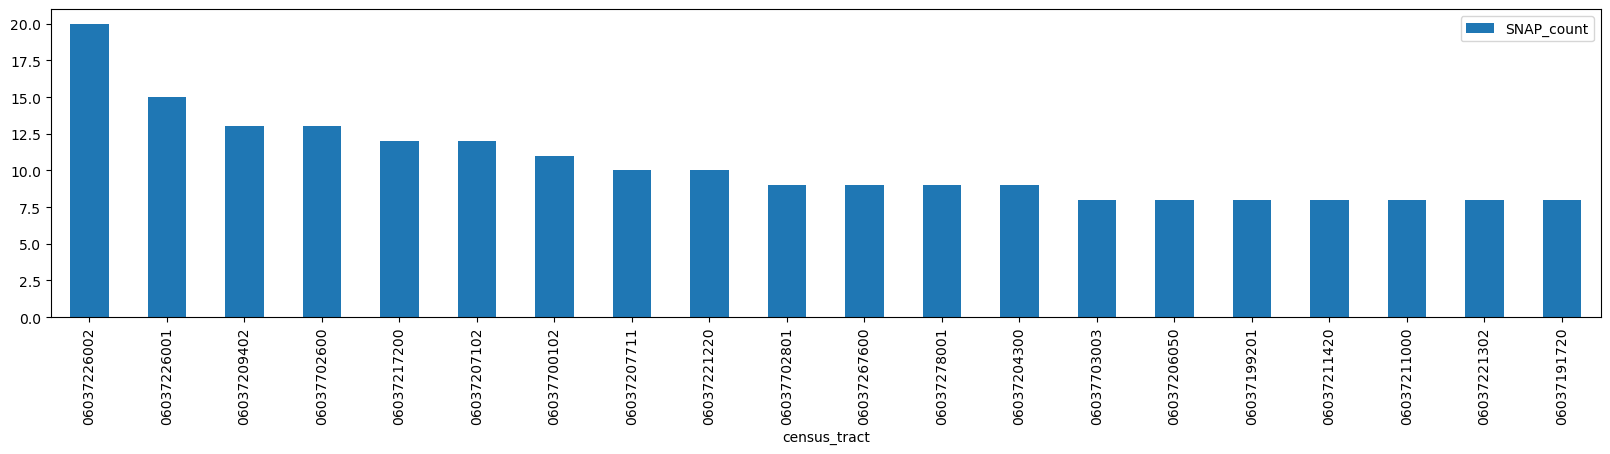

In [30]:
SNAP_by_tract[:20].plot.bar(figsize=(20,4),
                             x='census_tract',
                             y='SNAP_count')

We have the top 20 census tracts above, sorted by the amount of SNAP retailers they have. 

<Axes: ylabel='Frequency'>

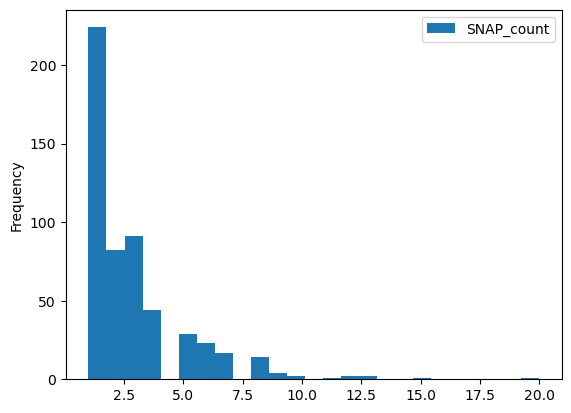

In [31]:
SNAP_by_tract.plot.hist(bins=25)

{'whiskers': [<matplotlib.lines.Line2D at 0x7aa2094cced0>,
 'caps': [<matplotlib.lines.Line2D at 0x7aa2094ce350>,
 'boxes': [<matplotlib.lines.Line2D at 0x7aa209e73c50>],
 'medians': [<matplotlib.lines.Line2D at 0x7aa2094cf210>],
 'fliers': [<matplotlib.lines.Line2D at 0x7aa2094cf990>],
 'means': []}

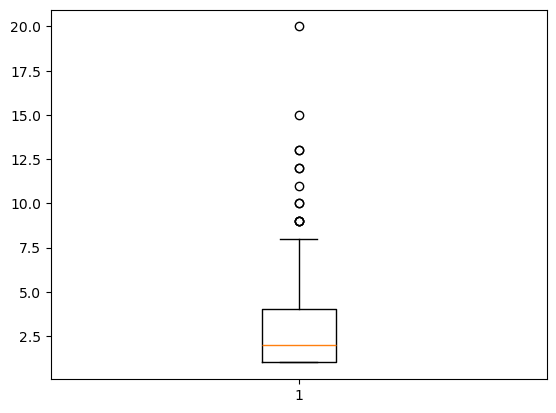

In [32]:
plt.boxplot(SNAP_by_tract.SNAP_count)

In [33]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth_Rate', 'Fertility_Rate', 'Low_Birth_Weight',
       'Low_Birth_Weight_Pctl', 'median_income', 'Grocery Store Access',
       'GSA_Percent', 'CalFresh_Cases', 'CF cases per 100'],
      dtype='object')

In [34]:
LBW = LBW.merge(SNAP_by_tract,on='census_tract')

In [35]:
LBW.sample(10)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Birth_Rate,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count
99,491,191902,1919.02,7.817628e+06,11569.812031,"POLYGON ((-13173728.010 4040501.800, -13173859...",06037191902,06037191902,0,6037191902,...,0.008105,0.030189,1.41,0.54,89583.0,0.0,0.000000,116.0,22.9,1
421,988,270300,2703.00,1.051131e+07,13672.051379,"POLYGON ((-13176410.142 4034577.318, -13176442...",06037270300,06037270300,0,6037270300,...,0.000000,0.000000,6.08,76.82,59327.0,0.0,0.000000,133.0,27.1,2
517,2274,702600,7026.00,2.339895e+07,24162.538532,"POLYGON ((-13179255.469 4029045.449, -13179257...",06037702600,06037702600,0,6037702600,...,0.009754,0.047982,4.64,42.20,110285.0,0.0,0.000000,171.0,10.1,13
105,497,192510,1925.10,3.667687e+06,8117.778674,"POLYGON ((-13169980.773 4039046.195, -13169863...",06037192510,06037192510,0,6037192510,...,0.020810,0.075805,8.33,97.66,54688.0,0.0,0.000000,282.0,31.0,2
196,588,206202,2062.02,4.067555e+06,9661.221437,"POLYGON ((-13162200.207 4034764.729, -13162202...",06037206202,06037206202,0,6037206202,...,0.003624,0.030726,0.00,0.00,12344.0,0.0,0.000000,520.0,315.2,4
270,662,212102,2121.02,1.492494e+06,4902.634445,"POLYGON ((-13169007.061 4037097.211, -13168954...",06037212102,06037212102,0,6037212102,...,0.017449,0.062587,6.63,85.46,31864.0,0.0,0.000000,424.0,86.4,2
185,577,204920,2049.20,9.794921e+06,12795.948168,"POLYGON ((-13157099.992 4030953.707, -13157100...",06037204920,06037204920,0,6037204920,...,0.020102,0.084718,7.11,90.89,59345.0,0.0,0.000000,219.0,41.3,2
348,915,261200,2612.00,8.170063e+07,59606.109484,"POLYGON ((-13185949.669 4046508.310, -13185975...",06037261200,06037261200,0,6037261200,...,0.002772,0.014440,3.52,16.63,178750.0,1895.0,0.436938,47.0,4.2,1
134,526,197410,1974.10,1.499700e+07,18531.588486,"POLYGON ((-13162907.643 4041727.853, -13162954...",06037197410,06037197410,0,6037197410,...,0.005935,0.020599,5.93,73.76,86414.0,0.0,0.000000,160.0,17.6,1
36,428,186403,1864.03,5.872994e+06,11992.562938,"POLYGON ((-13162235.830 4042878.884, -13162227...",06037186403,06037186403,0,6037186403,...,0.030147,0.145038,5.74,69.68,64412.0,0.0,0.000000,159.0,26.3,1


In [36]:
LBW = LBW.dropna(subset=['Low_Birth_Weight'])

In [37]:
LBW = LBW.dropna(subset=['Fertility_Rate'])

In [38]:
LBW.sort_values(by="Low_Birth_Weight").tail(20)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Birth_Rate,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count
273,665,212204,2122.04,2.294673e+06,6149.261568,"POLYGON ((-13167635.271 4036556.909, -13167339...",06037212204,06037212204,0,6037212204,...,0.000000,0.000000,7.96,96.24,33259.0,0.0,0.000000,402.0,60.2,2
143,535,199201,1992.01,4.253709e+06,8935.660564,"POLYGON ((-13159499.596 4039448.989, -13159575...",06037199201,06037199201,0,6037199201,...,0.003627,0.013570,7.97,96.29,51250.0,0.0,0.000000,396.0,51.8,8
188,580,206010,2060.10,1.548565e+07,21066.370822,"POLYGON ((-13161251.765 4038515.880, -13161222...",06037206010,06037206010,0,6037206010,...,0.031784,0.088040,8.02,96.51,41395.0,0.0,0.000000,483.0,61.3,2
154,546,201301,2013.01,9.323320e+06,19559.435790,"POLYGON ((-13156886.927 4041515.728, -13156887...",06037201301,06037201301,0,6037201301,...,0.007040,0.035714,8.02,96.51,66658.0,0.0,0.000000,306.0,35.7,2
225,617,208620,2086.20,3.491005e+06,8197.496402,"POLYGON ((-13166189.008 4038501.231, -13166297...",06037208620,06037208620,0,6037208620,...,0.022211,0.072639,8.06,96.72,52391.0,0.0,0.000000,360.0,37.9,5
31,423,186202,1862.02,4.394287e+06,11049.874479,"POLYGON ((-13160562.586 4045305.546, -13160612...",06037186202,06037186202,0,6037186202,...,0.009572,0.039014,8.13,96.97,83836.0,0.0,0.000000,123.0,25.6,4
5,397,183101,1831.01,1.041857e+07,17031.553974,"POLYGON ((-13156050.584 4046226.974, -13156157...",06037183101,06037183101,0,6037183101,...,0.011205,0.079457,8.14,97.04,59219.0,0.0,0.000000,198.0,32.6,6
105,497,192510,1925.10,3.667687e+06,8117.778674,"POLYGON ((-13169980.773 4039046.195, -13169863...",06037192510,06037192510,0,6037192510,...,0.020810,0.075805,8.33,97.66,54688.0,0.0,0.000000,282.0,31.0,2
158,550,201501,2015.01,9.566162e+06,14427.973812,"POLYGON ((-13153572.945 4040744.690, -13153574...",06037201501,06037201501,0,6037201501,...,0.015480,0.057249,8.35,97.68,69153.0,0.0,0.000000,382.0,33.3,5
79,471,190901,1909.01,5.276301e+06,9290.822749,"POLYGON ((-13170125.600 4041983.134, -13170317...",06037190901,06037190901,0,6037190901,...,0.001743,0.010802,8.38,97.75,39435.0,0.0,0.000000,440.0,56.6,5


In [39]:
LBW.sort_values(by="Total_Pop").head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Birth_Rate,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,1.0,0.0,1
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,0.0,0.0,0.0,0.0,250001.0,73.0,0.296748,1.0,6.3,1
207,599,207307,2073.07,5.259326e+05,2911.191793,"POLYGON ((-13163368.171 4034850.711, -13163260...",06037207307,06037207307,0,6037207307,...,0.0,0.0,0.0,0.0,12283.0,0.0,0.000000,453.0,415.6,3
205,597,207305,2073.05,2.182608e+06,8262.439763,"POLYGON ((-13163341.121 4035359.897, -13163191...",06037207305,06037207305,0,6037207305,...,0.0,0.0,0.0,0.0,72330.0,0.0,0.000000,108.0,73.5,3
371,938,265204,2652.04,2.855371e+06,7517.683586,"POLYGON ((-13185123.121 4036694.635, -13185108...",06037265204,06037265204,0,6037265204,...,0.0,0.0,0.0,0.0,108295.0,0.0,0.000000,86.0,47.5,7


In [40]:
LBW = LBW.astype({"Total_Pop":int})

In [41]:
LBW = LBW.query('Total_Pop > 20')

In [42]:
LBW['SNAP_per_1000'] = LBW['SNAP_count']/LBW['Total_Pop']*1000

In [43]:
LBW.sort_values(by="SNAP_per_1000").tail()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count,SNAP_per_1000
344,774,226002,2260.02,2.764534e+07,21400.411088,"POLYGON ((-13162719.512 4031973.365, -13162703...",06037226002,06037226002,0,6037226002,...,0.017884,5.83,71.64,37147.0,0.0,0.000000,336.0,127.8,20,5.575690
343,773,226001,2260.01,1.113812e+07,19074.269576,"POLYGON ((-13162774.838 4031971.753, -13162783...",06037226001,06037226001,0,6037226001,...,0.036873,5.24,58.56,34444.0,0.0,0.000000,216.0,53.7,15,5.699088
371,938,265204,2652.04,2.855371e+06,7517.683586,"POLYGON ((-13185123.121 4036694.635, -13185108...",06037265204,06037265204,0,6037265204,...,0.000000,0.00,0.00,108295.0,0.0,0.000000,86.0,47.5,7,5.922166
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,0.000000,0.00,0.00,250001.0,73.0,0.296748,1.0,6.3,1,7.812500
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,0.000000,0.00,0.00,NaN,0.0,0.000000,1.0,0.0,1,19.230769


In [44]:
LBW.dtypes

OBJECTID                          int64
CT20                             object
LABEL                            object
ShapeSTArea                     float64
ShapeSTLength                   float64
geometry                       geometry
tract_x                          object
census_tract                     object
Unnamed: 0                        int64
ignore                            int64
tract_y                           int64
sup_dist                         object
csa                              object
spa                              object
ESRI_OID                          int64
Shape__Area                     float64
Shape__Length                   float64
Total Woman 15-50                 int64
Women with births 12 Months       int64
Total_Pop                         int64
Birth_Rate                      float64
Fertility_Rate                  float64
Low_Birth_Weight                float64
Low_Birth_Weight_Pctl           float64
median_income                   float64


In [45]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth_Rate', 'Fertility_Rate', 'Low_Birth_Weight',
       'Low_Birth_Weight_Pctl', 'median_income', 'Grocery Store Access',
       'GSA_Percent', 'CalFresh_Cases', 'CF cases per 100', 'SNAP_count',
       'SNAP_per_1000'],
      dtype='object')

In [46]:
LBW2=LBW[["census_tract", "Low_Birth_Weight", "GSA_Percent", "SNAP_per_1000", "median_income", "CF cases per 100"]]
LBW2.head()

,census_tract,Low_Birth_Weight,GSA_Percent,SNAP_per_1000,median_income,CF cases per 100
0,06037181000,6.04,0.0,0.489237,107708.0,17.3
1,06037181300,7.11,0.0,1.107113,115174.0,14.1
2,06037181400,3.87,0.0,1.451379,85409.0,19.0
3,06037181500,5.93,0.0,0.547495,114034.0,16.2
4,06037181600,4.57,0.0,0.235460,90571.0,24.9


In [47]:
LBW2.corr(method='pearson', min_periods=1, numeric_only=True)

,Low_Birth_Weight,GSA_Percent,SNAP_per_1000,median_income,CF cases per 100
Low_Birth_Weight,1.000000,-0.141496,-0.033578,-0.196024,-0.092020
GSA_Percent,-0.141496,1.000000,-0.088518,0.522454,-0.057408
SNAP_per_1000,-0.033578,-0.088518,1.000000,-0.216259,0.061236
median_income,-0.196024,0.522454,-0.216259,1.000000,-0.195446
CF cases per 100,-0.092020,-0.057408,0.061236,-0.195446,1.000000


Here we run a Pearson's correlation analysis on our primary indicator variables. Rate of low gestational birthweight was weakly negatively associated with both median income and the proportion of residents living >1 mi from the nearest grocery store(low access rate), indicating that neighborhoods with lower grocery store access and higher income had more favorable reproductive health outcomes. Median income was strongly positively correlated with the low access rate, perhaps indicating that richer neighborhoods have low grocery store access but no associated health outcomes. SNAP retailer density and SNAP participation rates were weakly to moderately negatively correlated with median income, indicating that SNAP participating retailers are more concentrated in low income neighborhoods. 

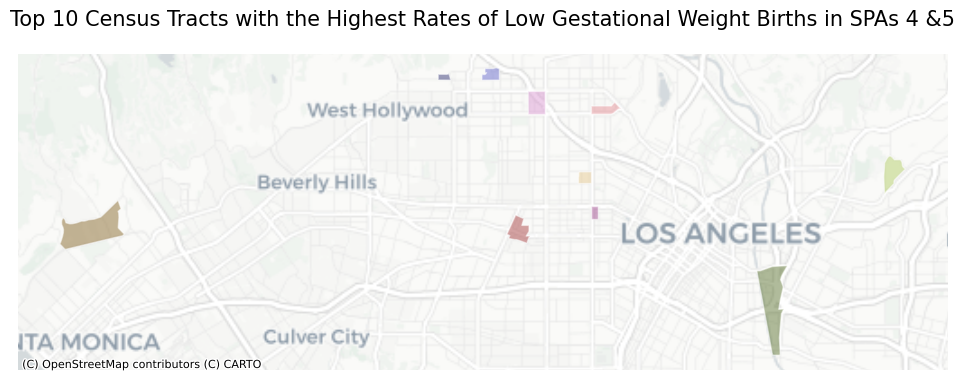

In [48]:
# map the top 10 geographies
fig,ax = plt.subplots(figsize=(12,12))
LBW.sort_values(by='Low_Birth_Weight',ascending=False)[:10].plot(ax=ax,
                                                                 cmap='tab20b',
                                                                 edgecolor='white',
                                                                 alpha=0.5)

# title
ax.set_title('Top 10 Census Tracts with the Highest Rates of Low Gestational Weight Births in SPAs 4 &5',fontsize=15,pad=20)


# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

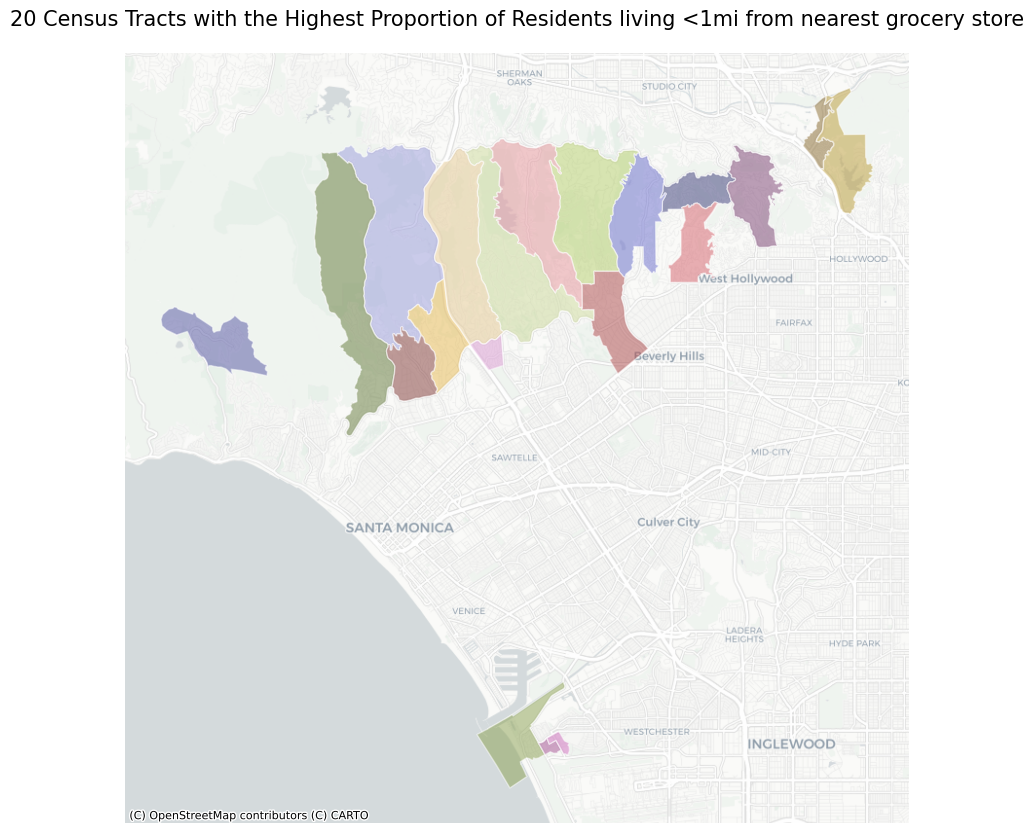

In [50]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
LBW.sort_values(by='GSA_Percent',ascending=False)[:20].plot(ax=ax,
                                                                 cmap='tab20b',
                                                                 edgecolor='white',
                                                                 alpha=0.5)

# title
ax.set_title('20 Census Tracts with the Highest Proportion of Residents living <1mi from nearest grocery store',fontsize=15,pad=20)


# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [51]:
LBW.sort_values(by="Low_Birth_Weight").tail(10)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility_Rate,Low_Birth_Weight,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count,SNAP_per_1000
43,435,188201,1882.01,8.354826e+06,17041.606203,"POLYGON ((-13165490.924 4043913.997, -13165502...",06037188201,06037188201,0,6037188201,...,0.000000,8.38,97.75,88786.0,0.0,0.000000,141.0,22.1,1,0.296033
272,664,212203,2122.03,1.144316e+06,4500.812926,"POLYGON ((-13167881.510 4036555.431, -13167881...",06037212203,06037212203,0,6037212203,...,0.000000,8.53,98.09,32750.0,0.0,0.000000,432.0,95.6,5,1.554726
87,479,191301,1913.01,2.944231e+06,8542.864193,"POLYGON ((-13167075.000 4041401.063, -13167182...",06037191301,06037191301,0,6037191301,...,0.000000,8.90,98.59,49405.0,0.0,0.000000,244.0,58.5,5,2.408478
284,676,212701,2127.01,5.054873e+06,10686.757287,"POLYGON ((-13171031.852 4036604.206, -13171055...",06037212701,06037212701,0,6037212701,...,0.011086,10.09,99.58,59196.0,0.0,0.000000,189.0,36.6,1,0.402091
256,648,211320,2113.20,2.004977e+06,5674.508818,"POLYGON ((-13168711.953 4038572.726, -13168711...",06037211320,06037211320,0,6037211320,...,0.000000,10.16,99.60,33247.0,0.0,0.000000,323.0,50.9,3,1.034840
361,928,264000,2640.00,2.010706e+07,22982.742080,"POLYGON ((-13188179.732 4036554.623, -13188174...",06037264000,06037264000,0,6037264000,...,0.076775,10.20,99.64,196250.0,8.0,0.002382,20.0,2.2,1,0.304507
161,553,201601,2016.01,5.816822e+06,11118.841894,"POLYGON ((-13155468.939 4039211.773, -13155547...",06037201601,06037201601,0,6037201601,...,0.106818,10.24,99.65,47465.0,0.0,0.000000,140.0,26.4,1,0.458085
190,582,206050,2060.50,1.921011e+07,25518.484734,"POLYGON ((-13160236.308 4032801.703, -13160228...",06037206050,06037206050,0,6037206050,...,0.070261,10.32,99.70,35795.0,0.0,0.000000,327.0,71.9,8,3.460208
67,459,190201,1902.01,2.441733e+06,6951.861667,"POLYGON ((-13172158.628 4042965.195, -13172177...",06037190201,06037190201,0,6037190201,...,0.005787,11.59,99.91,31403.0,0.0,0.000000,518.0,163.9,3,1.044568
60,452,189903,1899.03,9.037927e+05,4148.746180,"POLYGON ((-13174203.679 4042734.225, -13174242...",06037189903,06037189903,0,6037189903,...,0.000000,12.33,99.95,85745.0,0.0,0.000000,144.0,52.9,1,0.448833


In [53]:
wq =  lps.weights.KNN.from_dataframe(LBW,k=4)

In [54]:
wq.transform = 'r'

We have set our weights for the neighbor and row normalized the data. Next, we will add a column for the spatial lag in our LBW data frame

In [55]:
LBW['LBW_lag'] = lps.weights.lag_spatial(wq, LBW['Low_Birth_Weight'])

In [56]:
LBW.sample(10)[['census_tract','Total_Pop','GSA_Percent','Low_Birth_Weight','LBW_lag']]

,census_tract,Total_Pop,GSA_Percent,Low_Birth_Weight,LBW_lag
206,06037207306,2227,0.000000,0.00,0.0000
499,06037701402,6494,0.000000,4.97,5.5750
159,06037201503,3059,0.000000,5.72,6.7750
124,06037195710,3939,0.000000,4.65,4.9200
359,06037262706,3537,0.000281,0.00,3.4750
187,06037205120,3858,0.000000,5.88,6.0925
92,06037191610,4271,0.000000,5.83,6.1225
485,06037700400,5140,0.000000,3.59,3.1325
428,06037271702,4527,0.000000,2.76,1.8325
452,06037274202,4903,0.070471,4.96,3.3425


In [57]:
LBW['LBW_lag_diff'] = LBW['Low_Birth_Weight'] - LBW['LBW_lag']

Here we add a new column of spatial lag differences defined using the math query. 

In [58]:
LBW.sort_values(by='LBW_lag_diff')

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count,SNAP_per_1000,LBW_lag,LBW_lag_diff
65,457,190101,1901.01,2.415023e+06,6832.130177,"POLYGON ((-13173368.226 4042794.185, -13173477...",06037190101,06037190101,0,6037190101,...,0.00,34313.0,0.0,0.000000,217.0,151.7,5,2.729258,5.7625,-5.7625
75,467,190701,1907.01,4.762958e+06,9891.614212,"POLYGON ((-13172065.788 4042210.190, -13172066...",06037190701,06037190701,0,6037190701,...,0.00,36183.0,0.0,0.000000,356.0,180.7,3,1.606856,5.6125,-5.6125
140,532,199002,1990.02,1.447907e+07,20810.191024,"POLYGON ((-13159502.713 4039884.053, -13159491...",06037199002,06037199002,0,6037199002,...,0.00,62390.0,0.0,0.000000,274.0,44.4,4,1.373155,5.4525,-5.4525
191,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-13161437.780 4034377.954, -13161455...",06037206051,06037206051,0,6037206051,...,0.00,119453.0,6.0,0.002574,83.0,34.2,3,1.157854,5.3475,-5.3475
251,643,211123,2111.23,1.851716e+06,6798.256629,"POLYGON ((-13167126.095 4037247.039, -13167213...",06037211123,06037211123,0,6037211123,...,0.00,64348.0,0.0,0.000000,221.0,65.2,3,1.430615,5.0975,-5.0975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,603,207502,2075.02,4.503363e+06,9155.677193,"POLYGON ((-13164028.741 4036206.486, -13164097...",06037207502,06037207502,0,6037207502,...,95.16,17989.0,0.0,0.000000,1075.0,190.6,2,0.486263,1.3025,6.3875
361,928,264000,2640.00,2.010706e+07,22982.742080,"POLYGON ((-13188179.732 4036554.623, -13188174...",06037264000,06037264000,0,6037264000,...,99.64,196250.0,8.0,0.002382,20.0,2.2,1,0.304507,3.3750,6.8250
143,535,199201,1992.01,4.253709e+06,8935.660564,"POLYGON ((-13159499.596 4039448.989, -13159575...",06037199201,06037199201,0,6037199201,...,96.29,51250.0,0.0,0.000000,396.0,51.8,8,2.232143,0.0000,7.9700
67,459,190201,1902.01,2.441733e+06,6951.861667,"POLYGON ((-13172158.628 4042965.195, -13172177...",06037190201,06037190201,0,6037190201,...,99.91,31403.0,0.0,0.000000,518.0,163.9,3,1.044568,3.0575,8.5325


In [59]:
LBW_donut = LBW.sort_values(by='LBW_lag_diff').head(1)
LBW_donut

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count,SNAP_per_1000,LBW_lag,LBW_lag_diff
65,457,190101,1901.01,2.415023e+06,6832.130177,"POLYGON ((-13173368.226 4042794.185, -13173477...",06037190101,06037190101,0,6037190101,...,0.0,34313.0,0.0,0.0,217.0,151.7,5,2.729258,5.7625,-5.7625


In [60]:
LBW_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [61]:
LBW_diamond= LBW.sort_values(by='LBW_lag_diff').tail(1)
LBW_diamond

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low_Birth_Weight_Pctl,median_income,Grocery Store Access,GSA_Percent,CalFresh_Cases,CF cases per 100,SNAP_count,SNAP_per_1000,LBW_lag,LBW_lag_diff
60,452,189903,1899.03,903792.735352,4148.74618,"POLYGON ((-13174203.679 4042734.225, -13174242...",06037189903,06037189903,0,6037189903,...,99.95,85745.0,0.0,0.0,144.0,52.9,1,0.448833,2.2875,10.0425


In [62]:
LBW_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

The previous four code cells display the census tracts which are most dissimilar to their neighbors based on the Low Birth Weight lag difference. The donut has the highest rate of low birth weight relative to its neighbors whereas the diamond has the lowest. 

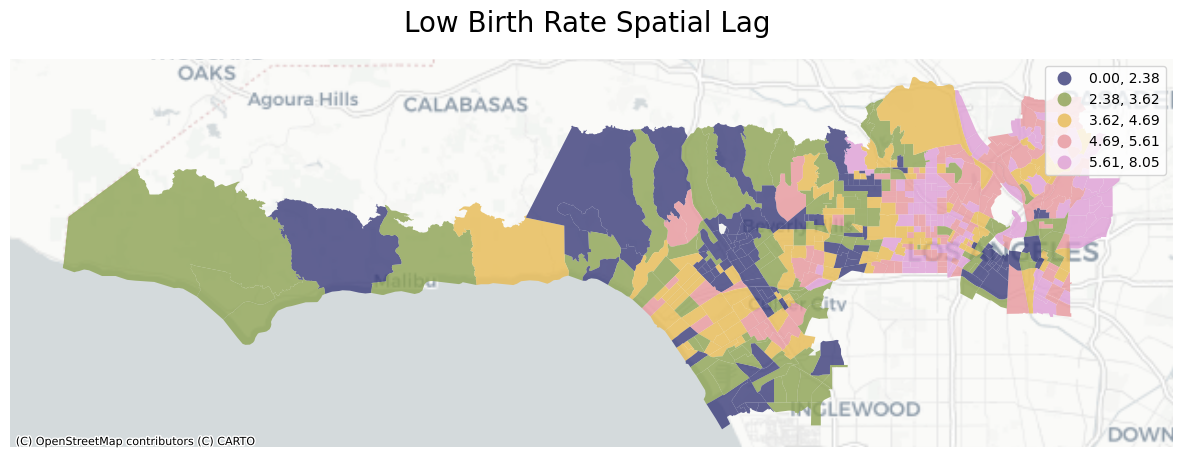

In [63]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
LBW.plot(ax=ax,
         figsize=(15,15),
         column='LBW_lag',
         legend=True,
         alpha=0.8,
         cmap='tab20b',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Low Birth Rate Spatial Lag ',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This plot displays the spatial lag of each of our census tracts. 

In [64]:
y = LBW.Low_Birth_Weight
moran = Moran(y, wq)
moran.I

0.3407064181227728

Our Moran value of 0.34 indicates a moderate positive local autocorrelation.

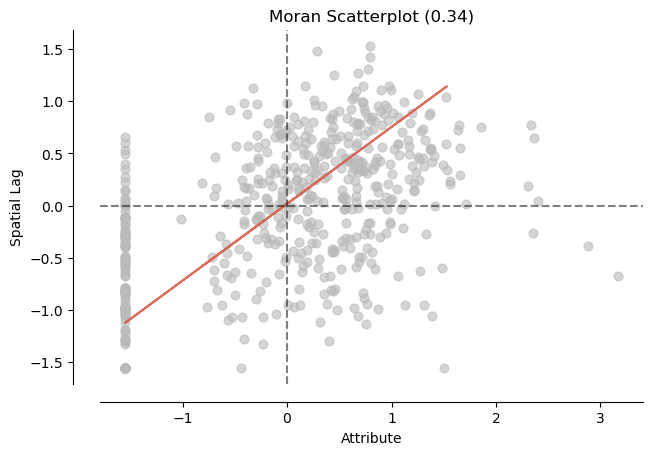

In [65]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.34', ylabel='Density'>)

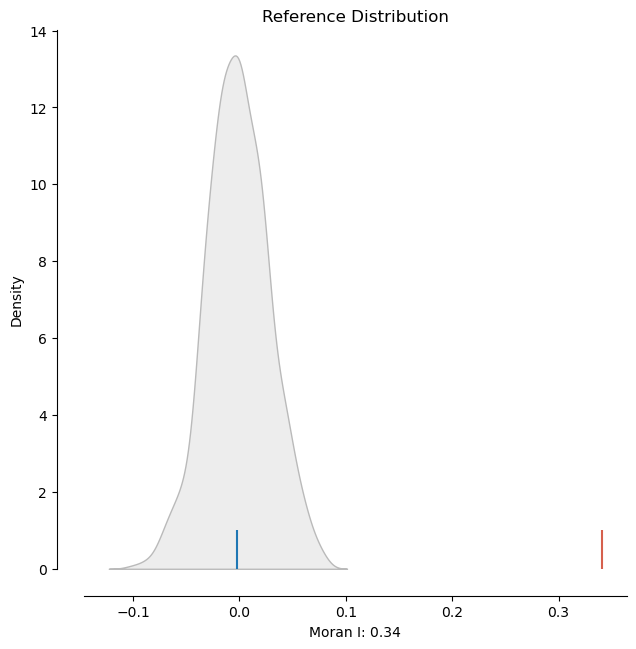

In [66]:
plot_moran_simulation(moran,aspect_equal=False)

In [67]:
moran.p_sim

0.001

Our Moran's P value is .001, which is below our alpha of .05, so we reject the null hypothesis that spatial pattern of low birth weight is randomly produced. Our p-value suggests that the spatial patterns in our analysis are capable of being produced by chance 1/1000 times. Plotted against the distribution of simulations we see that our observed spatial patterns are well without the realm of random chance outcomes.

In [68]:
lisa = esda.moran.Moran_Local(y, wq)

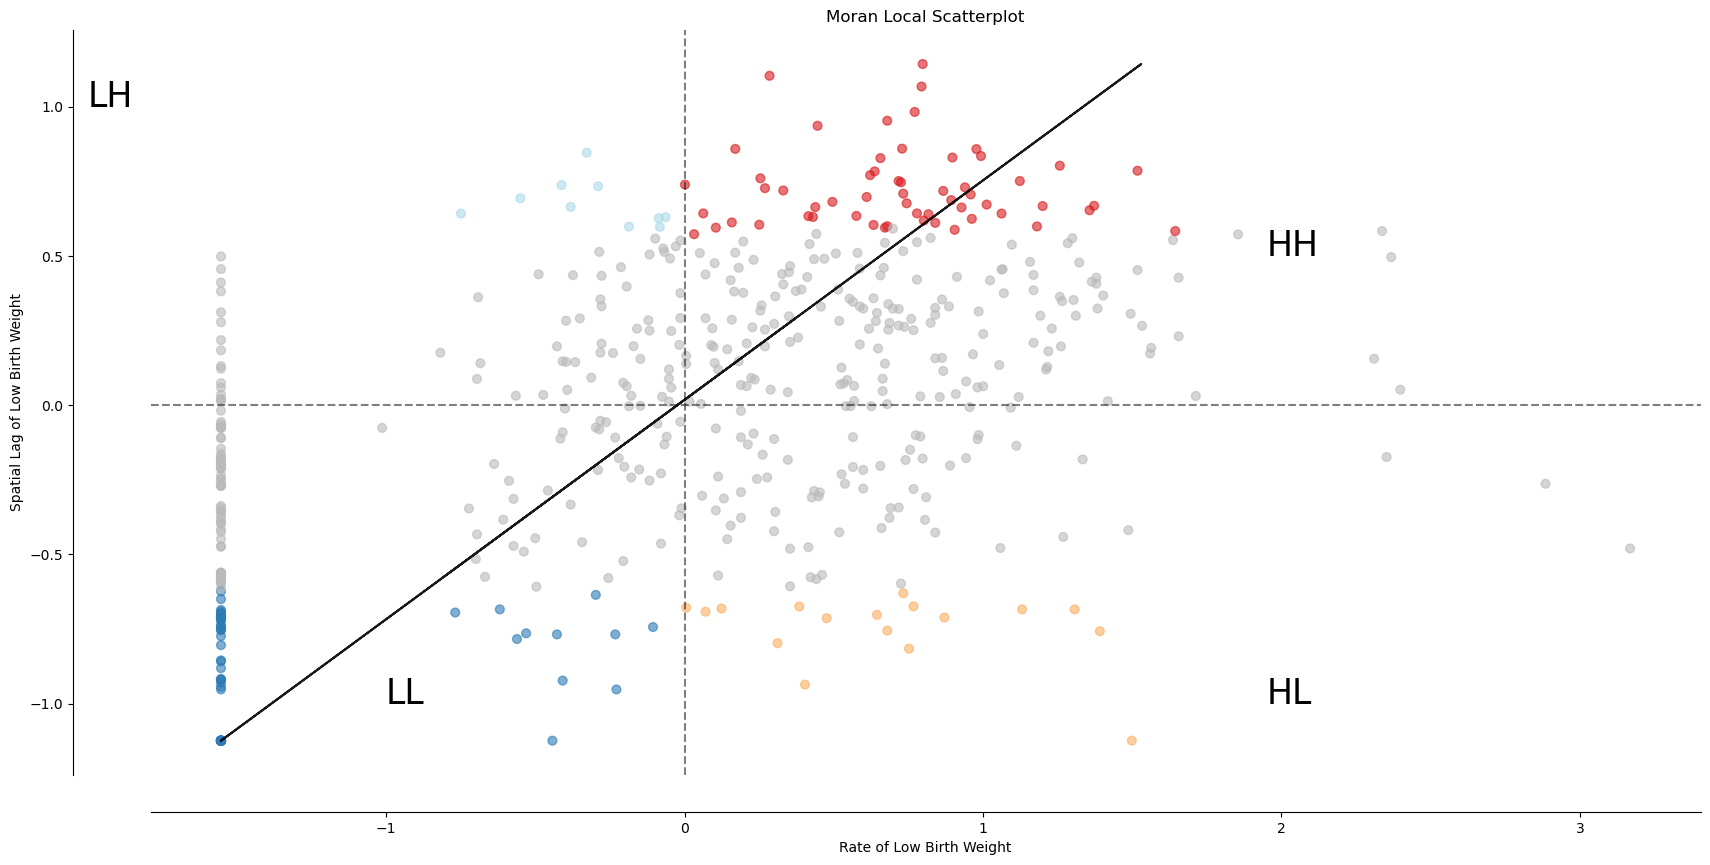

In [69]:
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Rate of Low Birth Weight")
ax.set_ylabel('Spatial Lag of Low Birth Weight')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

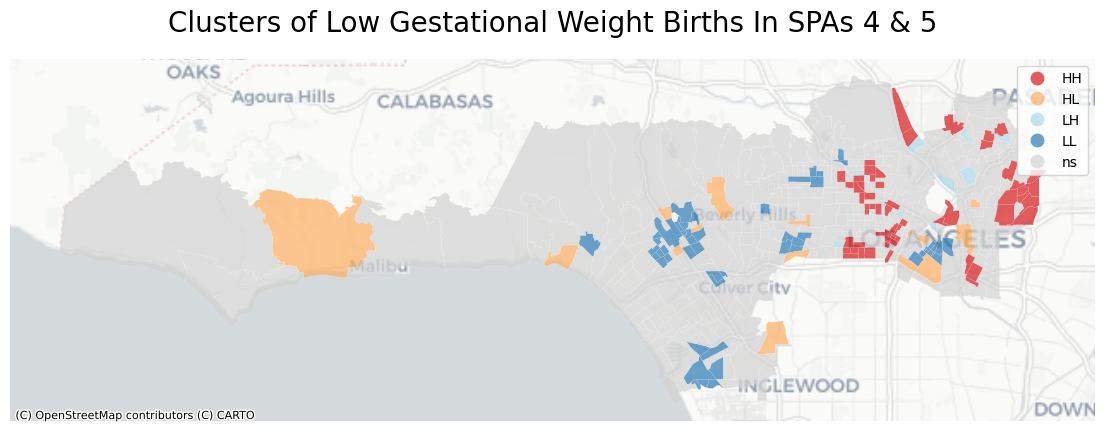

In [70]:
fig, ax = plt.subplots(figsize=(14,12))
ax.axis('off')
ax.set_title('Clusters of Low Gestational Weight Births In SPAs 4 & 5',fontsize=20,pad=20)
# add a basemap

lisa_cluster(lisa, LBW, p=0.05, ax=ax,alpha=.7)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()

Here is a plot and a map showing census tracts that are significantly correlated with their neighbors. HH indicates census tracts with high rates of low birth weight nearby others which also have high rates of negative reproductive outcomes. Patterns indicated: that clusters of alike high SNAP-acceptance retailers per population were found in the Fashion District, Skid Row, a group of census tracts around the LA River northeast of Skid Row, and a cluster in East Hollywood. Clusters of similar low LBW are found in the Westwood, Mar Vista/Playa del rey, and Hollywood areas.  Census tracts with high rates of low birth weight near CTs with low rates were found in the Palisades and Malibu mountain areas. CTs with low rates of low birth weights near CTs with high rates were found in Brentwood directly near UCLA as well as scattered areas in SPA 4. 



For the work breakdown of this assignment, all group members worked collaboratively on a Zoom call to code this notebook. We took turns sharing screens, and looking up information, and dropping code snippets to drive our data exploration. After we had finished the code breakdown, we all split up the markdowns throughout the report and worked on them either on the Jupyter Notebook or on a separate Google Doc, to later be added into the notebook. This was a truly collaborative group effort :)  